In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


In [3]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,SimpleRNN
from tensorflow.keras.models import Sequential

In [4]:
df=pd.read_csv('/kaggle/input/fake-news/train.csv')
df_test=pd.read_csv('/kaggle/input/fake-news/test.csv')
df.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
df = df.drop(columns=['id','author'],axis=1)
df=df.dropna(axis=0)

In [7]:
df.isnull().sum(),len(df)

(title    0
 text     0
 label    0
 dtype: int64,
 20203)

In [8]:
df['clean_news'] = df['title']+' '+df['text']
df['clean_news']=df['clean_news'].str.lower()
df['clean_news']=df['clean_news'].str.replace('[^A-Za-z0-9\s]','')
df['clean_news'].head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


0    house dem aide we didnt even see comeys letter...
1    flynn hillary clinton big woman on campus  bre...
2    why the truth might get you fired why the trut...
3    15 civilians killed in single us airstrike hav...
4    iranian woman jailed for fictional unpublished...
Name: clean_news, dtype: object

In [9]:
# 对测试集作数据预处理
df_test.isnull().sum()
df_test = df_test.drop(columns=['author'],axis=1)
#df_test=df_test.dropna(axis=0)
df_test = df_test.fillna('')
# replacing the null values with empty string

In [10]:
df_test['clean_news'] = df_test['title']+' '+df_test['text']

In [11]:
df_test['clean_news']=df_test['clean_news'].str.lower()
df_test['clean_news']=df_test['clean_news'].str.replace('[^A-Za-z0-9\s]','')
df_test['clean_news'].head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0    specter of trump loosens tongues if not purse ...
1    russian warships ready to strike terrorists ne...
2    nodapl native american leaders vow to stay all...
3    tim tebow will attempt another comeback this t...
4    keiser report meme wars e995 42 mins ago 1 vie...
Name: clean_news, dtype: object

In [12]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [13]:
df['clean_news']=df['clean_news'].apply(lambda x:" ".join([word for word in x.split() if word not in stop]))
df.head()

,title,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,flynn hillary clinton big woman campus breitba...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired truth might get fired oc...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,15 civilians killed single us airstrike identi...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jailed fictional unpublished sto...


In [14]:
# 去除测试集的停止词
df_test['clean_news']=df_test['clean_news'].apply(lambda y:" ".join([word for word in y.split() if word not in stop]))
df.head()

,title,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,flynn hillary clinton big woman campus breitba...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired truth might get fired oc...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,15 civilians killed single us airstrike identi...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jailed fictional unpublished sto...


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
tokenizer =Tokenizer()
tokenizer.fit_on_texts(df['clean_news'])
word_index=tokenizer.word_index
vocab_size=len(word_index)
vocab_size

187916

In [17]:
sequences=tokenizer.texts_to_sequences(df['clean_news'])
padded_seq=pad_sequences(sequences,maxlen=600,padding='post',truncating='post')

In [18]:
#测试集转换词向量
tokenizer.fit_on_texts(df_test['clean_news'])
sequences_test=tokenizer.texts_to_sequences(df_test['clean_news'])
padded_seq_test=pad_sequences(sequences_test,maxlen=600,padding='post',truncating='post')

In [19]:
padded_seq_test.shape

(5200, 600)

In [20]:
embedding_index={}
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values =line.split()
        word=values[0]
        coefs=np.asarray(values[1:],dtype='float32')
        embedding_index[word]=coefs

In [21]:
embedding_matrix=np.zeros((vocab_size+1,100))
for word,i in word_index.items():
    embedding_vector=embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [22]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13128   , -0.45199999,  0.043399  , ..., -0.30526   ,
        -0.045495  ,  0.56509   ],
       [-0.24683   , -0.045153  , -0.29971999, ..., -0.22978   ,
        -0.63699001, -0.78636003],
       ...,
       [ 0.14482   ,  0.17372   , -0.17934   , ..., -0.16463   ,
         0.77262002,  0.91674   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [23]:
padded_seq[5]

array([ 8974,  7492,  1345,     5,   415,     3,  7185,   183,   945,
        1082,  6035,  6874,  3024,   209,   147,   272,    22,  8974,
        7492,  1088,   447,   364,  3024,  4837,   147,    26,  8974,
        8260,  8416,   587,   183,   945,  2306,    11,    57,     3,
          14,   328,    95,  1345,   137,   194,   591,  1459,    20,
        5973,  2050,   611,    54,   327,  1924,  1968,   776,   247,
        8974,   141,  1897,  1345,   137,  3300,    31, 35717,     3,
          14,   328,   137,  3300,   875,   415,  3248,  7185,   213,
         447,  8974,  2306,     9,  2243, 13962,  8974,    10,   141,
        1579,  1345,  3563,   222,    95,    46,  1459,   419, 12811,
         275, 12926,   141,   112,  1291,   387,   304,   604,   349,
        3704,  1585,   644,   131,  4636, 20807,     7,    29,    59,
        8974,   141,   325,   197,   279,  1345, 24689,  1902,   197,
        1766,    89,    54,   534, 52410,   603,  4837,   273,  2429,
        8465,   110,

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_cv,Y_train,Y_cv=train_test_split(padded_seq,df['label'],test_size=0.2,random_state=42,stratify=df['label'])
X_train.shape,Y_train.shape,X_cv.shape,Y_cv.shape

((16162, 600), (16162,), (4041, 600), (4041,))

In [25]:
X_train[0]

array([   807,   9667,  11642,  35074,  23636,   1432,      6,     28,
           22,  21965,     32,  15072,    340,   1707,    340,  13851,
         1576,    260,   7826,  42425,  33332,  31861,   1837,      4,
          161,   1141,   7999,   2082,  19791,   3148,  11363,   1421,
         6125,   3044,    370,   2364,  16319,  15167,   1057,   5828,
         2132,     59,   7749,  12484,   1061,     93,    755,    804,
        10074,   6141,  12738,  14378,   1333,  23648,  19036,     45,
          836,   7974,   2037,   8230,  60857,   9667,  11642,   1326,
          371,    236,    117,   3168,    316,   1720,    395,    864,
        10516,   4637,   1443,    700,  12024,  20206,    517,   1720,
         5132,    447,   2080,  19036,  10878,   6037,    329,   1149,
         3317,   3171,     81,   1517,     17,    224,      4,    154,
         1057,   5172,   3944,   1032,  14943,    879,   1576,   6416,
           32,     53,   4388,   1239,      4,    154,   1057,   5172,
      

In [26]:
X_test=padded_seq_test

In [27]:
X_test.shape

(5200, 600)

In [48]:
model1=Sequential([
                 Embedding(vocab_size+1,100,weights=[embedding_matrix],trainable=False),
                 Dropout(0.2),
                 LSTM(units=128,return_sequences=False),
                 Dense(units=56),
                 Dense(units=1,activation='sigmoid')
                 
])
model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         18791700  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_14 (Dense)             (None, 56)                7224      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 57        
Total params: 18,916,229
Trainable params: 124,529
Non-trainable params: 18,791,700
_________________________________________________________________


In [ ]:
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
history1=model1.fit(X_train,Y_train,epochs=7,batch_size=128,validation_data=(X_cv,Y_cv))

Epoch 1/7
127/127 [==============================] - 161s 1s/step - loss: 0.1802 - accuracy: 0.9312 - val_loss: 0.1415 - val_accuracy: 0.9458
Epoch 2/7
111/127 [=========================>....] - ETA: 18s - loss: 0.1361 - accuracy: 0.9478

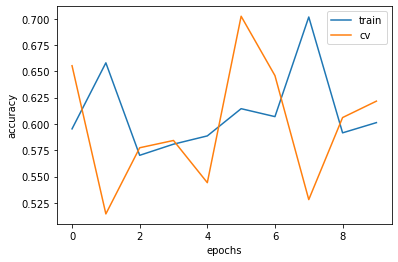

In [43]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('epochs');plt.ylabel('accuracy')
plt.legend(['train','cv'])
plt.show()

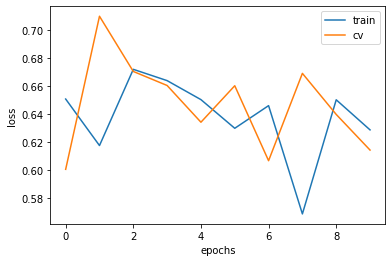

In [44]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('epochs');plt.ylabel('loss')
plt.legend(['train','cv'])
plt.show()

In [37]:
model2=Sequential([
                 Embedding(vocab_size+1,100,weights=[embedding_matrix],trainable=False),
                 SimpleRNN(units=56,return_sequences=False),
                 Dense(units=56),
                 Dense(units=1,activation='sigmoid')
                 
])
model2.summary()
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
history2=model2.fit(X_train,Y_train,epochs=5,batch_size=128,validation_data=(X_cv,Y_cv))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         18791700  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 56)                8792      
_________________________________________________________________
dense_6 (Dense)              (None, 56)                3192      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 57        
Total params: 18,803,741
Trainable params: 12,041
Non-trainable params: 18,791,700
_________________________________________________________________
Epoch 1/5
127/127 [==============================] - 47s 363ms/step - loss: 0.6766 - accuracy: 0.5667 - val_loss: 0.6697 - val_accuracy: 0.5526
Epoch 2/5
127/127 [==============================] - 45s 356ms/step - loss: 0.6630 - accura

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('epochs');plt.ylabel('accuracy')
plt.legend(['train','cv'])
plt.show()

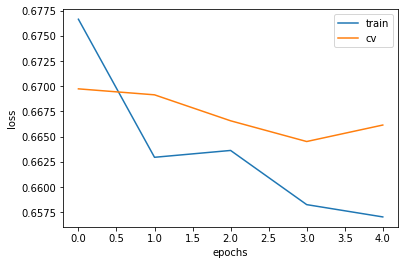

In [45]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epochs');plt.ylabel('loss')
plt.legend(['train','cv'])
plt.show()

In [ ]:
prediction1=model1.predict(X_test,batch_size=64,verbose=1)

In [ ]:
prediction1.shape

In [ ]:
Y_test_pred=np.where(prediction1 > 0.5, 1, 0)
df_test['label']=Y_test_pred

In [ ]:
from sklearn.metrics import f1_score
#Y_pred1=model1.predict(X_cv,batch_size=64,verbose=1)
Y_pred2=model2.predict(X_cv,batch_size=64,verbose=1)
#Y_pred1=np.where(Y_pred1>0.5,1,0)
Y_pred2=np.where(Y_pred2>0.5,1,0)
#print(f1_score(Y_cv,Y_pred1))
print(f1_score(Y_cv,Y_pred2))